In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.utils import shuffle

from keras.models import Sequential
from keras.layers import InputLayer, LSTM, Dense, Dropout
from keras.optimizers import Adam
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.constraints import MaxNorm
from keras.callbacks import ModelCheckpoint

In [2]:
filepath = 'C:/Users/ss230/Documents/Study/NSIDC/Edited Data/S_Sea_Ice_Index_Regional_Monthly_Data_G02135_v3.0.xlsx'
Ross_Extent = pd.read_excel(filepath, sheet_name='Ross-Extent-km^2')

In [3]:
import sys
sys.path.append('C:/Users/ss230/Documents/Study/NSIDC/SH/Bi_LSTM_Extent/')
import Function as fp

In [4]:
fp.month_mapping(Ross_Extent)
fp.date_time(Ross_Extent)

,Extent,Date
0,1040455.516,1979-01-01
1,239334.118,1979-02-01
2,557365.154,1979-03-01
3,2054855.924,1979-04-01
4,2973925.625,1979-05-01
...,...,...
533,3137598.938,2023-06-01
534,3201783.453,2023-07-01
535,2973294.266,2023-08-01
536,3354839.711,2023-09-01


In [5]:
scaler = MinMaxScaler()
Ross_Extent['Extent'] = scaler.fit_transform(Ross_Extent['Extent'].values.reshape(-1, 1))

In [6]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    lead_time = 3
    for i in range(len(df_as_np) - window_size - lead_time + 1):
        window_data = df_as_np[i:i+window_size]
        row = [[a] for a in window_data]
        X.append(row)
        label = df_as_np[i+window_size+lead_time-1]
        y.append(label)
    return np.array(X), np.array(y)

In [7]:
extent = Ross_Extent['Extent']
W_S=12
X,y = df_to_X_y(extent, W_S)
X.shape, y.shape

((524, 12, 1), (524,))

In [8]:
X_train, y_train = X[:420], y[:420]
X_val, y_val = X[420:472], y[420:472]
X_test, y_test = X[472:], y[472:]

In [9]:
model = Sequential()
model.add(InputLayer((W_S, 1)))
model.add(LSTM(128, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.5))
model.add(LSTM(64, activation='relu', kernel_constraint=MaxNorm(1.0), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32, activation='relu', kernel_constraint=MaxNorm(1.0)))
model.add(Dense(1, activation='linear'))

cp = ModelCheckpoint('Ross_model_LT3/', save_best_only=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(0.0001), metrics=[RootMeanSquaredError()])

In [10]:
import time

stime = time.time()
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=8, callbacks=[cp])
etime = time.time()

Epoch 1/50
53/53 [==============================] - 17s 214ms/step - loss: 0.3492 - root_mean_squared_error: 0.5909 - val_loss: 0.2240 - val_root_mean_squared_error: 0.4733
Epoch 2/50
53/53 [==============================] - 10s 192ms/step - loss: 0.1309 - root_mean_squared_error: 0.3618 - val_loss: 0.0687 - val_root_mean_squared_error: 0.2620
Epoch 3/50
53/53 [==============================] - 10s 188ms/step - loss: 0.0433 - root_mean_squared_error: 0.2081 - val_loss: 0.0506 - val_root_mean_squared_error: 0.2250
Epoch 4/50
53/53 [==============================] - 10s 195ms/step - loss: 0.0385 - root_mean_squared_error: 0.1963 - val_loss: 0.0448 - val_root_mean_squared_error: 0.2116
Epoch 5/50
53/53 [==============================] - 10s 183ms/step - loss: 0.0334 - root_mean_squared_error: 0.1826 - val_loss: 0.0382 - val_root_mean_squared_error: 0.1955
Epoch 6/50
53/53 [==============================] - 2s 31ms/step - loss: 0.0272 - root_mean_squared_error: 0.1649 - val_loss: 0.0402 - 

Epoch 30/50
53/53 [==============================] - 7s 133ms/step - loss: 0.0134 - root_mean_squared_error: 0.1156 - val_loss: 0.0179 - val_root_mean_squared_error: 0.1336
Epoch 31/50
53/53 [==============================] - 1s 28ms/step - loss: 0.0149 - root_mean_squared_error: 0.1219 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1350
Epoch 32/50
53/53 [==============================] - 1s 25ms/step - loss: 0.0137 - root_mean_squared_error: 0.1172 - val_loss: 0.0182 - val_root_mean_squared_error: 0.1350
Epoch 33/50
53/53 [==============================] - 8s 160ms/step - loss: 0.0144 - root_mean_squared_error: 0.1201 - val_loss: 0.0173 - val_root_mean_squared_error: 0.1314
Epoch 34/50
53/53 [==============================] - 10s 191ms/step - loss: 0.0144 - root_mean_squared_error: 0.1198 - val_loss: 0.0171 - val_root_mean_squared_error: 0.1307
Epoch 35/50
53/53 [==============================] - 2s 35ms/step - loss: 0.0137 - root_mean_squared_error: 0.1170 - val_loss: 0.0177 - 

In [11]:
time = (etime - stime)/60
print(f'{time} minutes')

5.997552573680878 minutes


In [12]:
loss = history.history['loss']
epochs = list(range(1, len(loss) + 1))

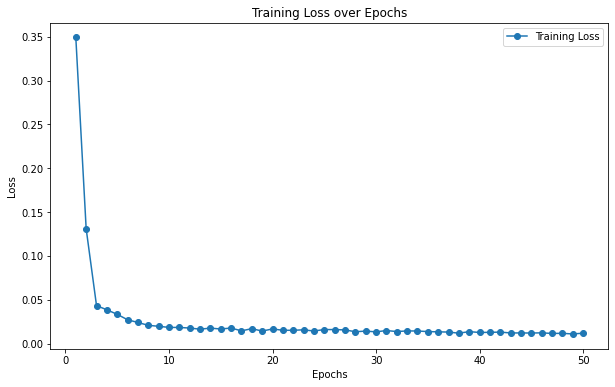

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss, label='Training Loss', marker='o', linestyle='-')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss over Epochs')
plt.legend()
plt.show()

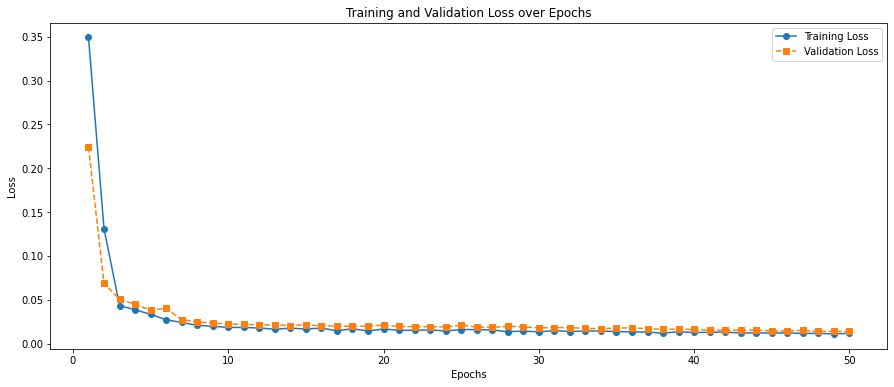

In [14]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(15,6))
plt.plot(epochs, training_loss, label='Training Loss', marker='o', linestyle='-')
plt.plot(epochs, validation_loss, label='Validation Loss', marker='s', linestyle='--')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.show()

In [15]:
from tensorflow.keras.models import load_model
model1 = load_model('Ross_model_LT3/')

In [16]:
test_predictions = model1.predict(X_test)

2/2 [==============================] - 1s 22ms/step


In [17]:
mse = mean_squared_error(y_test, test_predictions)
print('RMSE :', np.sqrt(mse))

mae = mean_absolute_error(y_test, test_predictions)
print('MAE :', mae)

RMSE : 0.11859703675874456
MAE : 0.10215561614889998


In [18]:
test_predictions = scaler.inverse_transform(test_predictions)
test_original = scaler.inverse_transform(y_test.reshape(-1,1))

In [19]:
train_results = pd.DataFrame(data={'Train Predictions': test_predictions.flatten(), 'Actual Extent': test_original.flatten()})
train_results

,Train Predictions,Actual Extent
0,3.527444e+06,3656196.531
1,3.822266e+06,3794128.369
2,3.814402e+06,3885746.442
3,3.603920e+06,3909211.179
4,3.167409e+06,3499167.351
5,2.333311e+06,2715890.297
6,1.325428e+06,1053272.694
7,9.203527e+05,368862.123
8,1.030069e+06,979418.298
9,1.443357e+06,2086269.569


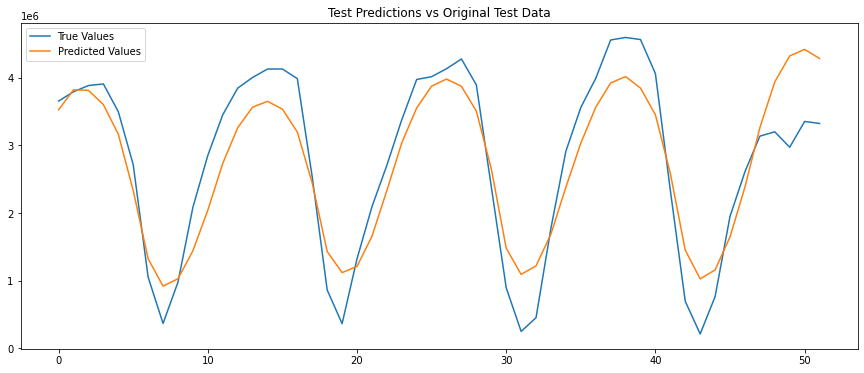

In [20]:
plt.figure(figsize=(15,6))
plt.plot(test_original, label='True Values')
plt.plot(test_predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()

In [21]:
predictions = model1.predict(X)

17/17 [==============================] - 0s 13ms/step


In [22]:
predictions = scaler.inverse_transform(predictions)
Original = scaler.inverse_transform(y.reshape(-1,1))

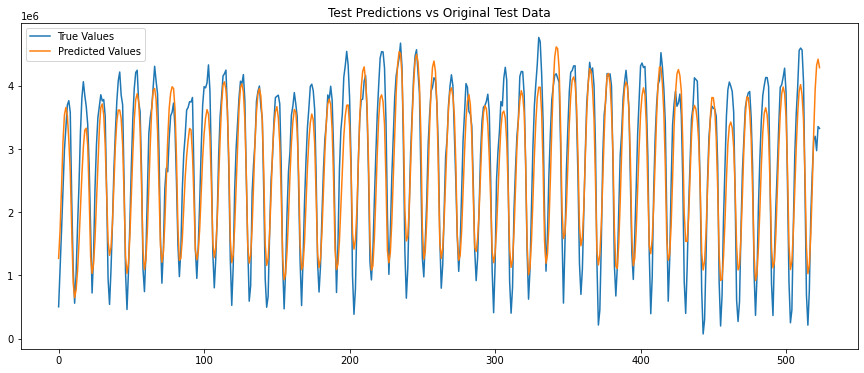

In [23]:
plt.figure(figsize=(15,6))
plt.plot(Original, label='True Values')
plt.plot(predictions, label='Predicted Values')
plt.title('Test Predictions vs Original Test Data')
plt.legend()
plt.show()